In [ ]:
!pip install pygimli==1.5.2 numpy==1.26

In [ ]:
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt
from pygimli.viewer.mpl import drawModel1D

from pygimli.physics import VESManager


import warnings
warnings.filterwarnings("ignore")

In [ ]:
def dateninversion(ab2, mn2, rhoa, nl, lam, errPerc):
    ves = VESManager()
    ves.invert(data=rhoa, error=errPerc, ab2=ab2, mn2=mn2,
           nLayers=nl,
           startModel=[10]*(nl-1)+[10]*nl,
           lam=lam, lambdaFactor=0.7,
           verbose=False
           )
    thknew = ves.model[0:nl-1]
    resnew = ves.model[nl-1:]
    rhoaresponse = ves.inv.response
    return resnew, thknew, rhoaresponse, ves.inv.relrms(), ves.inv.chi2()

def plotresults(res, thk, ab2, rhoa, rhoaresponse):
    fig, ax = plt.subplots(ncols=2, figsize=(14,6))
    drawModel1D(ax[0], thk, res, plot='semilogx', color='b', label='Inversionsmodell')
    ax[0].grid(True, which='both')
    ax[0].set_ylabel('Teufe in m')
    ax[0].set_xlabel(r'$\rho$ in $\Omega\cdot m$')
    ax[0].set_xlim((1.0, 2000.0))
    ax[0].legend(loc='best')

    ax[1].loglog(rhoa, ab2, 'rx-', label='Daten')
    ax[1].loglog(rhoaresponse, ab2, 'b-', label='Modellantwort')
    ax[1].set_ylim((max(ab2), min(ab2)))
    ax[1].set_xlim((10.0, 1000.0))
    ax[1].grid(True, which='both')
    ax[1].legend(loc='best')
    ax[1].set_xlabel(r'$\rho_s$ in $\Omega\cdot m$')
    ax[1].set_ylabel('AB/2 in m')

    plt.show()

def datenberechnen(ab2, mn2, res, thk, errPerc=0.0):
    nl = len(res)
    synthmodel = thk + res
    ves = VESManager()
    rhoa, err = ves.simulate(synthmodel, ab2=ab2, mn2=mn2, noiseLevel=0.01, seed=1337)
    return ves, rhoa, err

def plotdata(rhoa, ab2):
    fig, ax = plt.subplots()
    ax.loglog(ab2, rhoa, 'rx-', label='Daten')
    ax.set_xlim((min(ab2), max(ab2)))
    ax.set_ylim((10.0,1000.0))
    ax.set_xlabel('AB/2 in m')
    ax.set_ylabel(r'$\rho_s$ in $\Omega\cdot m$')
    ax.legend(loc='best')
    ax.grid(True, which='both')
    plt.show()

def datenvergleichen(rhoa, rhoanew, ab2):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.loglog(ab2, rhoa, 'rx-', label='Daten')
    ax.loglog(ab2, np.array(list(rhoanew)), 'b-', label='Modellantwort')
    ax.set_xlim((1.0, 100.0))
    ax.set_ylim((10.0,1000.0))
    ax.set_xlabel('AB/2 in m')
    ax.set_ylabel(r'$\rho_s$ in $\Omega\cdot m$')
    ax.legend(loc='best')
    ax.grid(True, which='both')
    plt.show()

**Bedienungsanleitung:** Alle Zellen mit der Markierung `In [..]:` enthalten Python-Code. Zum Ausführen des Codes nutzen Sie die Tastenkombination `Shift-Return`. Die jeweils aktive ausführbare Zelle erkennen Sie am Rahmen mit dem grünen vertikalen Balken sowie der Markierung `In [..]:` am linken Rand.

Bei der ersten Ausführung der Zelle `In [1]:` kann es zu einer Warnmeldung kommen, welche ignoriert werden kann.

**Aufgabenstellung:** Arbeiten Sie das Notebook ab. In der Tabelle vor Code-Zelle 2 `In [2]:` finden Sie die Daten für eine geoelektrische Widerstandstiefensondierung $\rho_s(AB/2)$. Diese sind in Code-Zelle 2 `In [2]:` bereits in die Python-Arrays `ab2` und `rhoa` eingetragen worden.

Damit bleibt für Sie die Aufgabe, spezifische Widerstände $\rho_i$, $i=1,2,3$ und Mächtigkeiten $h_i$, $i=1,2$ eines horizontalgeschichteten Dreischichtfalls zu bestimmen. Mit vorgegebenen Startwerten erzeugen Sie zunächst eine synthetische Sondierungskurve. Durch gezielte Veränderungen der Werte von $\rho_i$ und $h_i$ versuchen Sie dann, die gemessene und synthetische Sondierungskurve schrittweise in bestmögliche Übereinstimmung zu bringen.

Im Abschluss können Sie eine automatische Anpassung (*geophysikalische Dateninversion*) durchführen, um optimale Werte für $\rho$ und $h$ zu erhalten.

Für das Protokoll verwerten Sie die erzeugten Abbildungen sowie die Zahlenwerte für $\rho_i$ und $h_i$.

# Auswertung einer Widerstandstiefensondierung
## Grundlagen der Methode

Bei einer Widerstandstiefensondierung werden scheinbare spezifische elektrische Widerstände $\rho_s$ aufgezeichnet.
Dabei wird der Abstand der Stromelektroden A ud B unter Beibehaltung des Mittelpunktes der Anordnung schrittweise vergrößert.
Ist der Abstand zwischen den Potentialsonden M und N immer kleiner als AB/3, sprechen wir von einer *Schlumbergeranordnung*.

Die Geoelektrik-Apparatur misst dabei elektrische Spannungen zwischen den Sonden M und N sowie den zwischen den Elektroden A und B fließenden elektrischen Strom.
Daraus wird mit der Beziehung
$$
R = \frac{U}{I} \quad\text{  in  } \Omega
$$
zunächst der Ohmsche Widerstand ermittelt.
Dieser wird mit dem Konfigurationsfaktor für die Schlumbergeranordnung
$$
k = \frac{\pi}{\text{MN}}\left( \frac{\text{AB}^2}{4} - \frac{\text{MN}^2}{4} \right)
$$
multipliziert.

Wir erhalten auf diese Weise den scheinbaren spezifischen elektrischen Widerstand
$$
\rho_s = R \cdot k \quad\text{  in  } \Omega\cdot m.
$$

Das folgende Bild zeigt eine typische Sondierungskurve, zu deren Interpretation ein Dreischichtfall hinreichend ist.

![Sondierungskurve](https://github.com/ruboerner/pg/blob/master/soundingcurve.png?raw=1)

## Auswertung
Das Ziel der Auswertung besteht in der Ermittlung der *spezifischen Widerstände* und *Mächtigkeiten* von Bodenschichten unter der Annahme einer näherungsweise horizontalen Lagerung.
Die Messwerte werden zunächst graphisch als *Sondierungskurve* $\rho_s = f(AB/2)$ dargestellt.
Aus dem Kurvenverlauf schätzt man die minimale Anzahl von Schichten ab.


Für die Auswertung benutzen wir die Python-Bibliothek pygimli ([www.pygimli.org](http://www.pygimli.org)).

Dazu importieren wir das Modul `functions`.

Die Daten wurden für logarithmisch äquidistante Positionen der Stromelektroden aufgenommen.
<!---

Wir fassen die Messwerte in einer Tabelle zusammen:

| AB/2 in m | $\rho_s$ in $\Omega\cdot m$ |
|-------------|-----------------------------|
| 1.0 | 195.07 |
 |1.3   | 197.25 |
 |1.8  | 186.88 |
 |2.4   | 162.47 |
 |3.2   | 127.12 |
 |4.2   | 89.57 |
 |5.6   | 55.84 |
 |7.5   | 33.14 |
 |10.0   | 29.21 |
 |13.0   | 31.63 |
 |18.0   | 42.90 |
 |24.0   | 57.91 |
 |32.0   | 72.59 |
 |42.0   | 96.33 |
 |56.0   | 121.64 |
 |75.0   | 168.55 |
 |100.0   | 204.98 |

Für alle Werte von AB/2 war der Abstand der Potentialsonden immer 0.6 m, d.h., MN/2 = 0.3 m.
-->
Wir fassen die Messwerte in den *Python*-Arrays `ab2`, `mn2` und `rhoa` zusammen. Die Richtung der Profilauslage wird in den Variablennamen durch Anhängen von ``_EW`` bzw. ``_NS`` gekennzeichnet.

In [ ]:
ab2_EW = np.array([1.0, 1.3, 1.8,
                2.4, 3.2, 4.2,
                4.2, 5.6, 7.5,
                10, 13, 18,
                24, 32, 42])
mn2_EW = np.array([0.3, 0.3, 0.3,
                0.3, 0.3, 0.3,
                1.0, 1.0, 1.0,
                1.0, 1.0, 1.0,
                1.0, 1.0, 1.0
               ])
rhoa_EW = np.array([138.18, 121.56, 106.22,
                109.55, 114.79, 118.26,
                112.39, 116.84, 125.58,
                131.25, 129.04, 97.92,
                90.23, 90.63, 76.16
                ])

In [ ]:
ab2_NS = np.array([1.00, 1.30, 1.80,
        2.40, 3.20, 4.20,
        5.60, 7.50, 10.00,
        13.00, 18.00, 24.00, 32.00
])
mn2_NS = np.array([0.30, 0.30, 0.30,
    0.30, 0.30, 0.30, 0.30,
    1.00, 1.00, 1.00, 1.00,
    1.00, 1.00
])
rhoa_NS = np.array([134.36, 117.62, 114.13,
    110.14, 99.12, 98.05,
    94.76, 106.13, 111.96,
    120.07, 113.65, 92.58, 55.44
])

### Visualisierung der Sondierungskurven

Sondierungskurven werden in doppeltlogarithmischer Skalierung dargestellt. Auf der x-Achse werden die halben Elektrodenabstände (AB/2), auf der y-Achse die scheinbaren spezifischen Widerstände $\rho_s$ abgetragen.

Im Idealfall einer horizontalen, ebenen Schichtung müssen die Messwertkurven der Kreuzsondierungen übereinanderliegen.
Abweichungen kommen zustande, wenn der Untergrund komplizierter aufgebaut ist (keine horizontale Lagerung, dreidimensionale Einlagerungen usw.).

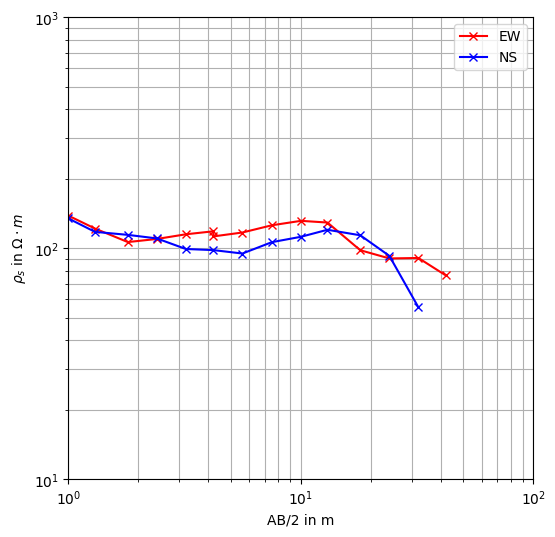

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(ab2_EW, rhoa_EW, 'rx-', label='EW')
ax.loglog(ab2_NS, rhoa_NS, 'bx-', label='NS')
ax.set_xlim((1.0, 100.0))
ax.set_ylim((10.0,1000.0))
ax.set_xlabel('AB/2 in m')
ax.set_ylabel(r'$\rho_s$ in $\Omega\cdot m$')
ax.legend(loc='best')
ax.grid(True, which='both')
plt.show()

### Modellanpassung

Wir versuchen jetzt durch Probieren, die gemessene Sondierungskurve mit einer anhand eines Modells berechneten Sondierungskurve in Übereinstimmung zu bringen.

Dafür tragen wir in das Array `res` die Zahlenwerte für die spezifischen elektrischen Widerstände (in $\Omega\cdot m$) der drei Schichten beginnend an der Erdoberfläche (vom Hangenden zum Liegenden) ein:

In [ ]:
res = [180.0, 100.0, 300.0]

Die Zahlenwerte der Mächtigkeiten dieser Schichten (in m) fassen wir im Array `thk` zusammen. Beachten Sie, dass die Mächtigkeit der letzten Schicht (des Substratums) nach unten hin unbegrenzt ist und daher in `thk` weggelassen wird.

In [ ]:
thk = [1.5, 5.5]

Die Funktion `datenberechnen` berechnet die scheinbaren spezifischen Widerstände, die wir bei einer Messung über einem Dreischichtfall mit den spezifischen Widerständen und Mächtigkeiten für die vorgegebenen Stromelektrodenabstände erhalten würden:

In [ ]:
ab2 = ab2_NS
mn2 = mn2_NS
rhoa = rhoa_NS
ves, rhoanew, err = datenberechnen(ab2, mn2, res, thk)

Die so erhaltenen Ergebnisse (*Modellantwort*) `rhoanew` stellen wir gemeinsam mit den Messwerten (*Daten*) `rhoa` grafisch in Abhängigkeit vom Elektrodenabstand AB/2 `ab2` dar.

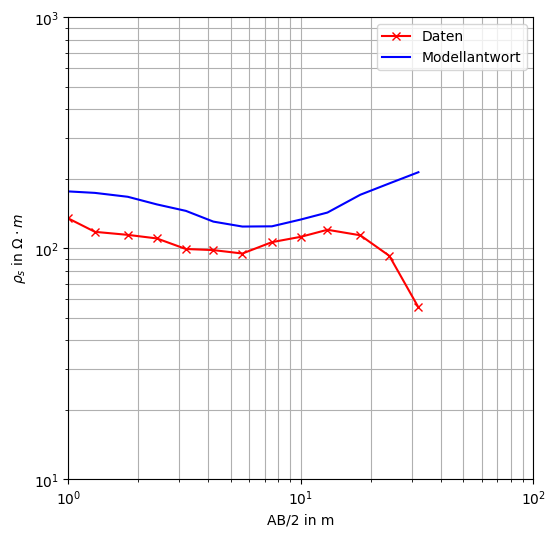

In [ ]:
datenvergleichen(rhoa, rhoanew, ab2)

Da wir eine möglichst gute Übereinstimmung beider Kurven anstreben, ist es u.U. nötig, zur Definition von `res` und `thk` zurückzukehren, um die Rechnung mit veränderten Werten zu wiederholen.

Notieren Sie die Werte von `res` und `thk`, wenn Sie zufrieden sind mit der Anpassung.

In [ ]:
resbest = res
thkbest = thk

### Automatische Modellfindung
Für eine automatische Ermittlung der spezifischen Widerstände `res` und Mächtigkeiten `thk` wird das Verfahren der geophysikalischen Dateninversion eingesetzt.

Dabei wird ein aus den Messwerten erzeugtes Startmodell mit `nl` Schichten systematisch verändert, bis dessen Modellantwort mit den gemessenen Daten bis auf eine vorgegebene Abweichung `errPerc` übereinstimmt.
Der Parameter `lam` steuert, wie groß die Sprünge zwischen den spezifischen Widerständen der einzelnen Schichten sein dürfen.

In [ ]:
nl = 3
lam = 500.0
errPerc = 10.0

resnew, thknew, rhoaresponse, relrms, chi2 = dateninversion(ab2, mn2, rhoa, nl, lam, errPerc)

04/09/24 - 15:00:31 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%


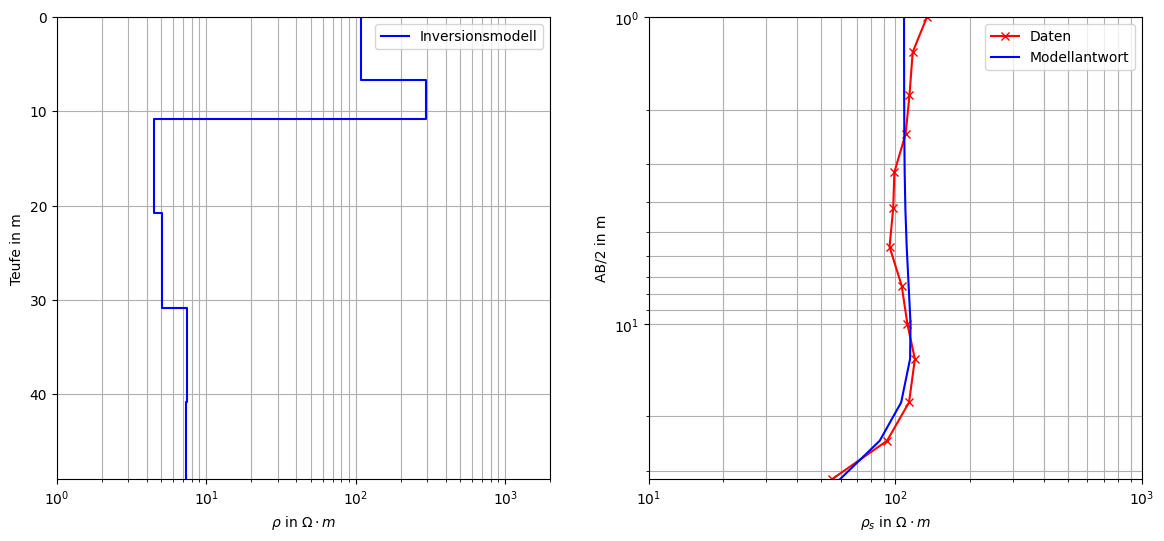

In [ ]:
plotresults(resnew, thknew, ab2, rhoa, rhoaresponse)

## Zusammenfassung der Resultate
### Spezifische elektrische Widerstände

In [ ]:
print("Spezifische elektrische Widerstände in Ohm*m:")
for r in resnew:
    print(f'{r:8.2f}')

Spezifische elektrische Widerstände in Ohm*m:
  108.47
  295.64
    4.49
    5.09
    7.40
    7.32


### Mächtigkeiten

In [ ]:
print("Schichtmächtigkeiten in m:")
for t in thknew:
    print(f'{t:8.2f}')

Schichtmächtigkeiten in m:
    6.66
    4.15
    9.98
   10.08
   10.00


### Bewertung der Anpassug
Die Güte der Anpassung wird durch die Summe der Quadrate der Differenzen zwischen den gemessenen und synthetischen Werten der Sondierungskurve bestimmt.

Wir unterscheiden zwischen *relativem RMS-Fehler* und $\chi^2$-*Fehler*.

In [ ]:
print("Relativer RMS-Fehler = ", f'{relrms:.2f}')
print("chi^2-Fehler         = ", f'{chi2:.2f}')

Relativer RMS-Fehler =  9.73
chi^2-Fehler         =  96.43


## Weiterführende Analyse
### Schichtäquivalenz
Bei der manuellen bzw. automatischen Anpassung erhalten wir für die zweite Schicht folgende Werte für den spezifischen Widerstand und die Schichtmächtigkeit:

In [ ]:
print("Manuelle Anpassung:")
print("Spezifischer Widerstand der zweiten Schicht:" + f'{resbest[1]:8.2f}' + " Ohm*m")
print("Mächtigkeit der zweiten Schicht            :" + f'{thkbest[1]:8.2f}' + " m")
print("Automatische Anpassung:")
print("Spezifischer Widerstand der zweiten Schicht:" + f'{resnew[1]:8.2f}' + " Ohm*m")
print("Mächtigkeit der zweiten Schicht            :" + f'{thknew[1]:8.2f}' + " m")

Manuelle Anpassung:
Spezifischer Widerstand der zweiten Schicht:  100.00 Ohm*m
Mächtigkeit der zweiten Schicht            :    5.50 m
Automatische Anpassung:
Spezifischer Widerstand der zweiten Schicht:  295.64 Ohm*m
Mächtigkeit der zweiten Schicht            :    4.15 m


Für eine dünne Schicht mit Mächtigkeit $h$ und niedrigem Widerstand $\rho$, die in einer Formation mit hohem spezifischen Widerstand eingebettet ist, gilt die Schichtäquivalenz. Dies bedeutet, dass die gesamte Sondierungskurve nahezu unverändert bleibt, sofern das Verhältnis
$$
S_i = \frac{h_i}{\rho_i} = const.
$$
gleich bleibt.
Die Größe $S_i$ wird Längsleitfähigkeit der Schicht $i$ genannt.
Ihre physikalische Einheit ist *Siemens*.
Die Längsleitfähigkeit ist die einzige Information über die zweite Schicht, die bei der vorliegenden geoelektrischen Widerstandstiefensondierungen sicher bestimmt werden kann.
Eine unabhängige Bestimmung von spezifischem Widerstand oder Mächtigkeit der zweiten Schicht ist dagegen nicht möglich.
Man spricht vom *Äquivalenzprinzip der Geoelektrik*.

In [ ]:
print("Manuelle Anpassung:")
print("Längsleitfähigkeit der zweiten Schicht:" + f'{thkbest[1]/resbest[1]:8.2f}' + " S")
print("Automatische Anpassung:")
print("Längsleitfähigkeit der zweiten Schicht:" + f'{thknew[1]/resnew[1]:8.2f}' + " S")

Manuelle Anpassung:
Längsleitfähigkeit der zweiten Schicht:    0.06 S
Automatische Anpassung:
Längsleitfähigkeit der zweiten Schicht:    0.01 S
